In [54]:
import pandas as pd
import numpy as np

In [55]:
articles = pd.read_csv('articles.csv')

# ANALYSIS & PRE PROCESSING

In [56]:
articles.drop_duplicates(subset=None, keep='first', inplace=False).isna().sum()

document_id        0
title              0
category        7615
publish_time    5451
number_views       0
keywords        5219
author          6238
dtype: int64

In [57]:
articles = articles[['document_id','title','category','keywords', 'author']]
#articles.dropna(inplace=True)
articles.reset_index(inplace=True)

In [58]:
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random

In [59]:
#Preprocessing

def make_lower_case(text):
    try:
        return text.lower()
    except:
        return ""

# Function for removing stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("norwegian"))
    text = [w for w in text if not w in stops]
    texts = [w for w in text if w.isalpha()]
    texts = " ".join(texts)
    return texts

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

# Function for removing the html tags
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [60]:
articles['cleaned_title'] = articles['title'].apply(func = make_lower_case)
articles['cleaned_title'] = articles.cleaned_title.apply(func = remove_stop_words)
articles['cleaned_title'] = articles.cleaned_title.apply(func=remove_punctuation)

articles['category'] = articles['category'].apply(func = make_lower_case)
#articles['category'] = articles.category.apply(func = remove_stop_words)
#articles['category'] = articles.category.apply(func=remove_punctuation)

articles['keywords'] = articles['keywords'].apply(func = make_lower_case)
articles['keywords'] = articles.keywords.apply(func = remove_stop_words)
articles['keywords'] = articles.keywords.apply(func=remove_punctuation)

articles['author'] = articles['author'].apply(func = make_lower_case)
articles['author'] = articles.author.apply(func = remove_stop_words)
articles['author'] = articles.author.apply(func=remove_punctuation)

In [61]:
#We then generate the content text adding the different features
articles['text'] = articles.cleaned_title + articles.category + articles.keywords + articles.author

# MODELING

In [62]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

## analyzer -- to select individual words# default 
## max_df[0.0,1.0] - used to ignore words with frequency more than 0.8 these words can be useless words as these words may appear only once and may not have a significant meaning
## min_df -- Selected as low as posible due to memory limitations in order to retain the most information.
## use_idfbool, default=True  -- Enable inverse-document-frequency reweighting.

tf = TfidfVectorizer(analyzer='word',stop_words=set(stopwords.words("norwegian")),max_df=0.8,min_df=0.0,use_idf=True,ngram_range=(1,3))
tfidf_matrix = tf.fit_transform(articles['text'])

In [63]:
tfidf_matrix

<20344x171245 sparse matrix of type '<class 'numpy.float64'>'
	with 280203 stored elements in Compressed Sparse Row format>

In [64]:
def recomendation(idxs,no_of_news_article, with_score = False):
    #recomendation vector (sum of watched articles vector)
    recomendation_vector = np.sum(tfidf_matrix[idxs],axis=0)
    
    #get similarity values with other articles
    similarity_score =  enumerate(linear_kernel(tfidf_matrix, recomendation_vector))
    
    # Filter visited articles
    similarity_score = [k for k in similarity_score if k[0] not in idxs]
    
    #Sort articles by similarity
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the n most similar news articles. Ignore the first movie.
    similarity_score = similarity_score[0:no_of_news_article]
    if with_score:
        return similarity_score
    '''
    print("Article"+" -- IDX " + str(idx) + " -- Title : " + articles['title'].iloc[idx] + " -- Document ID : " + articles['document_id'].iloc[idx])
    print(" ---------------------------------------------------------- ")'''
    news_indices = [i[0] for i in similarity_score]
    '''
    for i in range(len(news_indices)):
        print("Recomendation " + str(i+1) + " -- IDX " + str(news_indices[i]) + " -- Title : " + articles['title'].iloc[news_indices[i]] + " -- Document ID : " + articles['document_id'].iloc[idx] + " -- score : " + str(similarity_score[i][1]))
        print()'''
    return news_indices

In [65]:
user_viewed = [12, 15, 300, 4000, 54, 658, 45, 4001]
no_of_news_article=10
recomendation(user_viewed,no_of_news_article, with_score=True)

[(3989, array([1.])),
 (7157, array([0.28577553])),
 (734, array([0.27416922])),
 (735, array([0.27416922])),
 (3848, array([0.25818984])),
 (17599, array([0.24039547])),
 (2133, array([0.22545005])),
 (4762, array([0.22133826])),
 (17821, array([0.19504226])),
 (2441, array([0.192391]))]

# EVALUATION

In [28]:
from collections import Counter
np.random.seed(42)
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

def evaluate(users, batch_size):
    eval = []
    j = 0
    for i, user in users.iterrows():
        user_articles_id = events[events.user_id == user.user_id].document_id.dropna().unique()
        user_articles = articles[articles.document_id.isin(user_articles_id)].index
        #filter articles
        user_articles = [k for k in user_articles if k in articles.index]
        
        idxs = np.random.choice(user_articles, batch_size)
        predicted = recomendation(idxs, batch_size)
        eval.append(len(intersection(user_articles, predicted)))
        '''        
        if(j== 10):
            break
        else:
            j += 1'''
    print(np.mean(eval)/batch_size)

In [29]:
users = pd.read_csv('users.csv')
events = pd.read_csv('events.csv')


In [15]:
#with dropna
evaluate(users, 10)
evaluate(users, 30)
evaluate(users, 100)

0.08199999999999999
0.09369999999999999
0.08827


In [31]:
#whith-out dropna
evaluate(users, 10)
evaluate(users, 30)
evaluate(users, 100)

0.09230000000000001
0.09613333333333333
0.08891


In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA, TruncatedSVD
pca= TruncatedSVD(3)
pca.fit(tfidf_matrix)
print(pca.explained_variance_)

[0.00263998 0.00092161 0.00095928]


In [67]:
tfidf_matrix_pca = pca.transform(tfidf_matrix)
print("original shape:   ", tfidf_matrix.shape)
print("transformed shape:", tfidf_matrix_pca.shape)

original shape:    (20344, 171245)
transformed shape: (20344, 3)


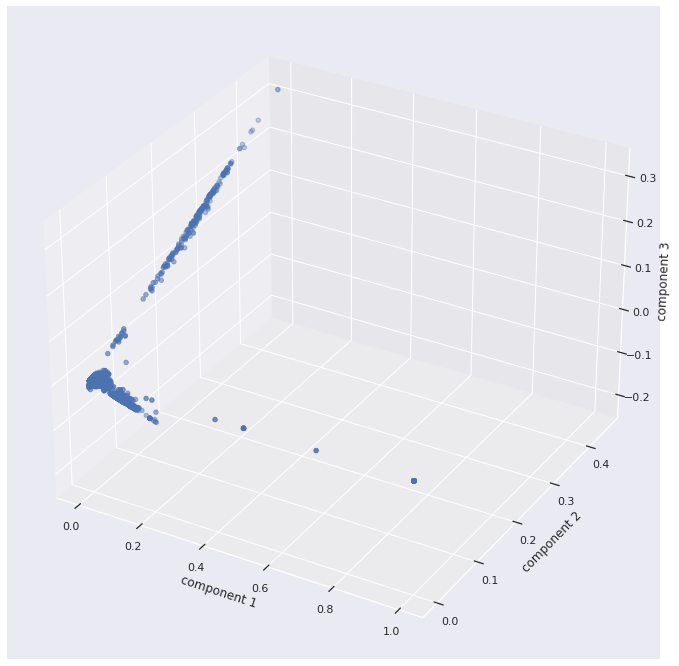

In [68]:
#without normalization
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(tfidf_matrix_pca[:,0], tfidf_matrix_pca[:,1], tfidf_matrix_pca[:,2], marker='o')
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set_zlabel('component 3')

plt.show()